In [5]:
!pip install pytorch-lightning==1.7.7
!pip install pytorch-lightning-bolts
!pip install wandb gym

You should consider upgrading via the 'D:\Learning\EVA_8\venv\Scripts\python.exe -m pip install --upgrade pip' command.


^C
  Cloning https://github.com/Lightning-Universe/lightning-bolts to c:\users\ajink\appdata\local\temp\pip-req-build-tulgu41a
  Resolved https://github.com/Lightning-Universe/lightning-bolts to commit 2dfe45a4cf050f120d10981c45cfa2c785a1d5e6
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached pytorch_lightning-1.8.6-py3-none-any.whl (800 kB)
  Using cached tensorboardX-2.6-py2.py3-none-any.whl (114 kB)
  Created wheel for lightning-bolts: filename=lightning_bolts-0.7.0.dev0-py3-none-any.whl size=332869 sha256=33779890447b81493b66e976fcda40ae496953a7b1a61f48b992a494dcca8d70
  Stored in directory: C:\Users\ajink\AppData\Local\Temp\pip-ephem-wheel-cache-mz7wsylp\wheels\fa\80\ac\639b69ce54ed0e19466e19

  Running command git clone --filter=blob:none --quiet https://github.com/Lightning-Universe/lightning-bolts 'C:\Users\ajink\AppData\Local\Temp\pip-req-build-tulgu41a'
You should consider upgrading via the 'D:\Learning\EVA_8\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
!pip freeze

absl-py==1.4.0
aiofiles==22.1.0
aiohttp==3.8.4
aiosignal==1.3.1
aiosqlite==0.18.0
albumentations==1.3.0
anyio==3.6.2
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arrow==1.2.3
asttokens==2.2.1
async-timeout==4.0.2
attrs==22.2.0
Babel==2.11.0
backcall==0.2.0
beautifulsoup4==4.11.2
bleach==6.0.0
cachetools==5.3.0
certifi==2022.12.7
cffi==1.15.1
charset-normalizer==2.1.1
click==8.1.3
cloudpickle==2.2.1
colorama==0.4.6
comm==0.1.2
contourpy==1.0.6
cycler==0.11.0
debugpy==1.6.6
decorator==5.1.1
defusedxml==0.7.1
docker-pycreds==0.4.0
einops==0.6.0
entrypoints==0.4
executing==1.2.0
fastjsonschema==2.16.3
fire==0.5.0
fonttools==4.38.0
fqdn==1.5.1
frozenlist==1.3.3
fsspec==2023.4.0
future==0.18.3
gitdb==4.0.10
GitPython==3.1.31
google-auth==2.17.3
google-auth-oauthlib==1.0.0
grad-cam==1.4.6
grpcio==1.54.0
gym==0.26.2
gym-notices==0.0.8
idna==3.4
imageio==2.25.1
ipykernel==6.21.2
ipython==8.10.0
ipython-genutils==0.2.0
ipywidgets==8.0.4
isoduration==20.11.0
jedi==0.18.2
Jinja2

In [20]:
import matplotlib.pyplot as plt

def plot_generations():
    mnist.setup()
    data_loader = mnist.train_dataloader()

    for batch in data_loader:
        image, label = batch
        output = VAE(image)
        plt.imshow(output)

In [29]:
import pytorch_lightning as pl
import torch
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=28):
        super().__init__()

        self.save_hyperparameters()

        # convolution to increase channels from 1 to 3
        self.conv = nn.Conv2d(1, 3, kernel_size=3, padding=1)
        
        # convolution to decrease channels from 3 to 1
        self.conv_dec = nn.Conv2d(3, 1, kernel_size=3, padding=1)
        
        # fc layer to increase label channels from 10 to 256 (the size of embedding)
        self.fc = nn.Linear(10, 256)
        
        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim+10, 
            input_height=input_height, 
            first_conv=False, 
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        x, labels = batch
        labels_ohe = F.one_hot(labels, num_classes=10)
        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(self.conv(x))
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        
        '''
        i=0
        if i==0:
            i=1
            print(z.size())
            print(x.size())
            n = F.interpolate(x, scale_factor=2)
            print(n.size())
            n2 = F.interpolate(n, scale_factor=1)
            print(n2.size())
        '''
        # decoded 
        x_hat = self.conv_dec(F.interpolate(vae.decoder(torch.cat((z, labels_ohe.to(torch.float32)), dim=1)), size=28))
        
        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(), 
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

    def forward(self, x, label):
        labels_ohe = F.one_hot(label, num_classes=10)
        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(self.conv(x))
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        
        '''
        i=0
        if i==0:
            i=1
            print(z.size())
            print(x.size())
            n = F.interpolate(x, scale_factor=2)
            print(n.size())
            n2 = F.interpolate(n, scale_factor=1)
            print(n2.size())
        '''
        # decoded 
        x_hat = self.conv_dec(F.interpolate(vae.decoder(torch.cat((z, labels_ohe.to(torch.float32)), dim=1)), size=28))
        
        return x_hat
        

In [30]:
from pl_bolts.datamodules import MNISTDataModule

mnist = MNISTDataModule('.')

In [50]:
pl.seed_everything(1234)

vae = VAE()
trainer = pl.Trainer(gpus=1, max_epochs=10)
trainer.fit(vae, mnist)

Global seed set to 1234
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type          | Params
-------------------------------------------
0 | conv     | Conv2d        | 30    
1 | conv_dec | Conv2d        | 28    
2 | fc       | Linear        | 2.8 K 
3 | encoder  | ResNetEncoder | 11.2 M
4 | decoder  | ResNetDecoder | 8.7 M 
5 | fc_mu    | Linear        | 131 K 
6 | fc_var   | Linear        | 131 K 
-------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params


Training: 0it [00:00, ?it/s]

1

tensor([6, 7, 6, 9, 4, 2, 1, 3, 8, 9, 7, 0, 3, 1, 2, 4, 6, 1, 4, 5, 3, 6, 5, 5,
        6, 5, 1, 4, 6, 8, 6, 1])
tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6,
        7, 8, 9, 1, 2, 3, 4, 5])


C:\Users\ajink\AppData\Local\Temp\ipykernel_15660\1492028295.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


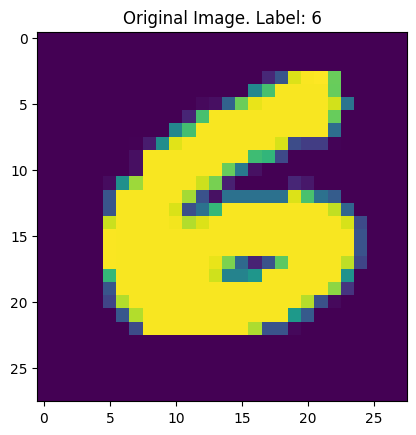

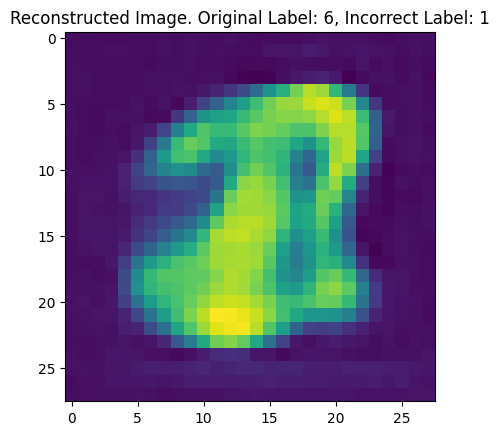

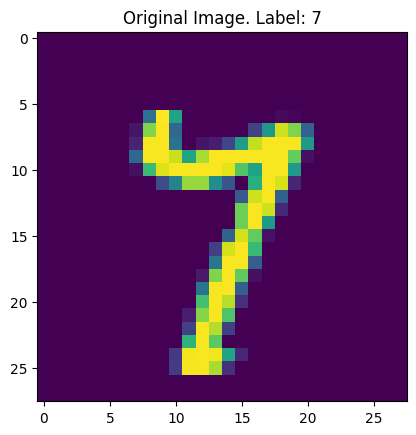

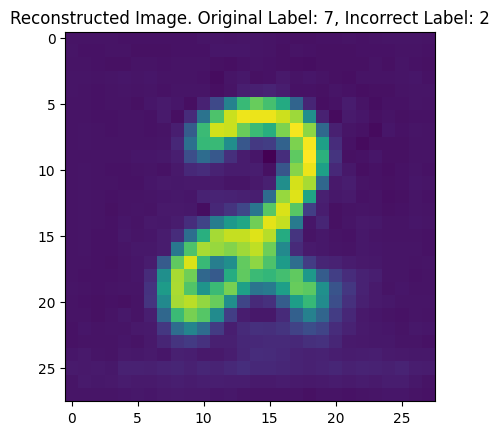

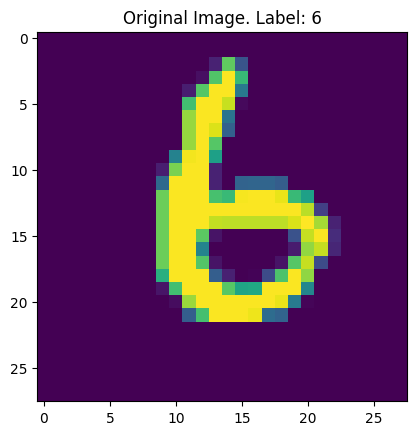

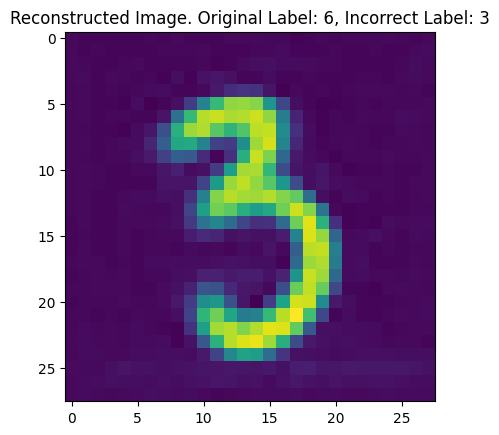

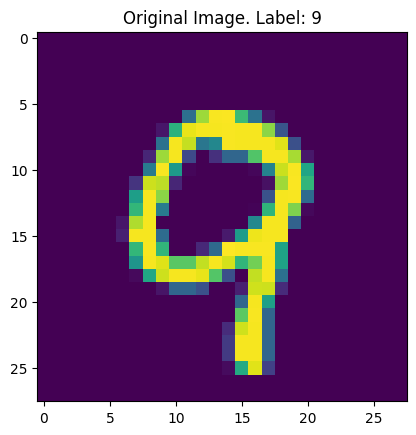

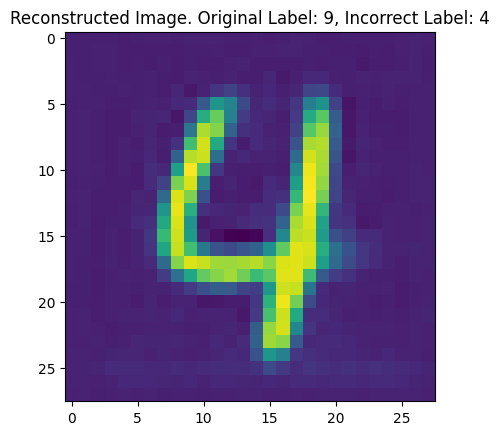

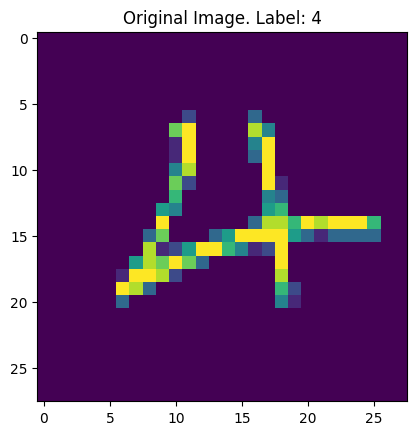

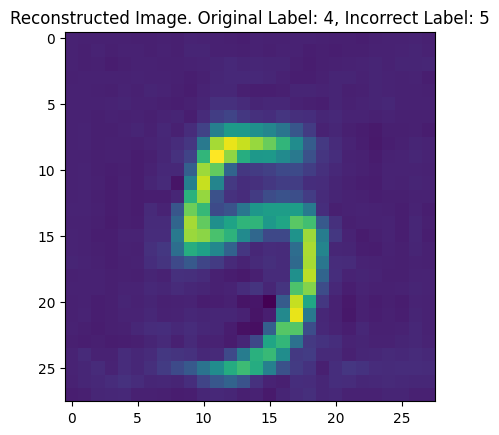

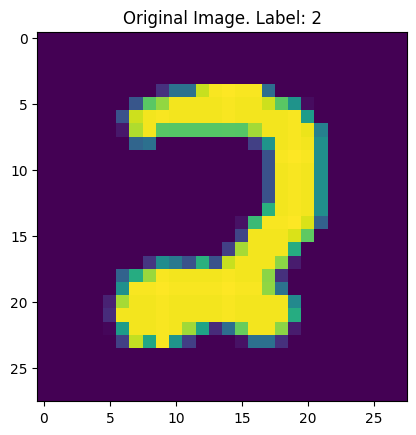

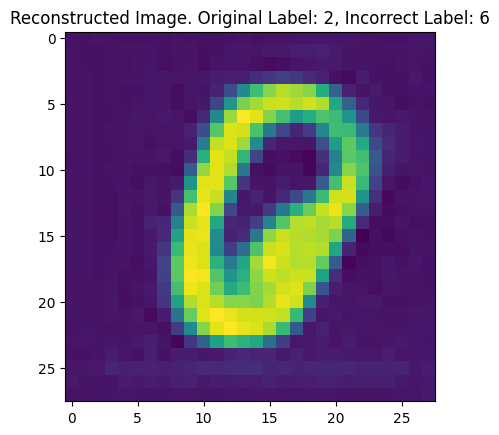

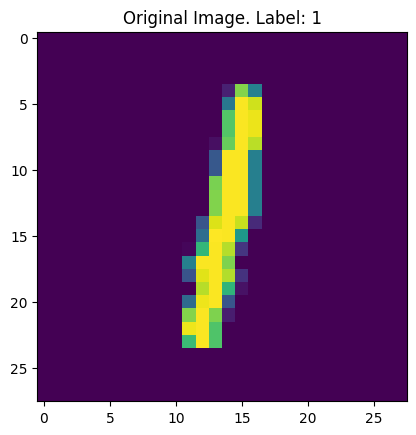

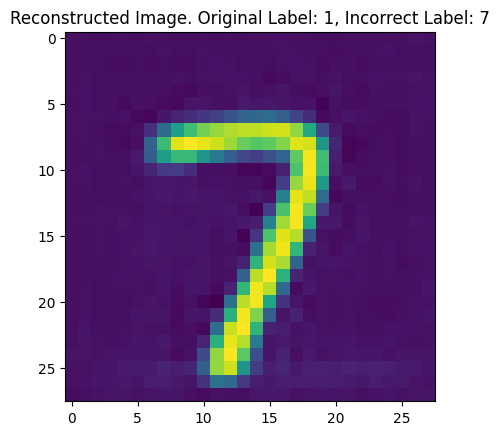

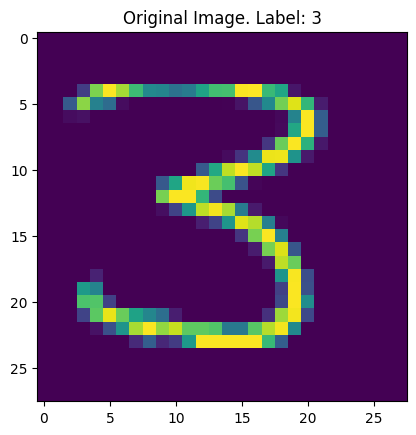

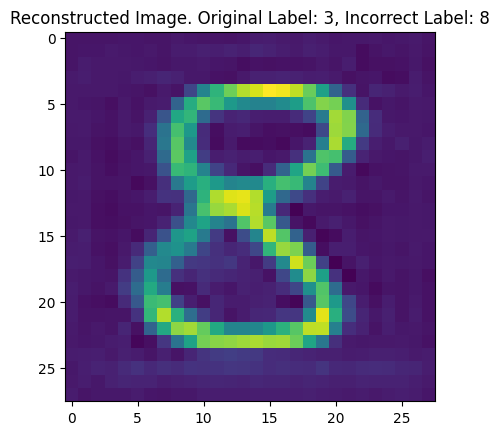

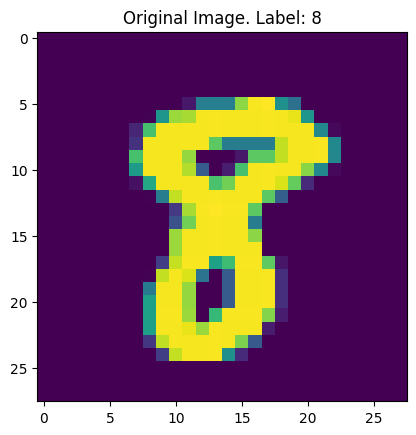

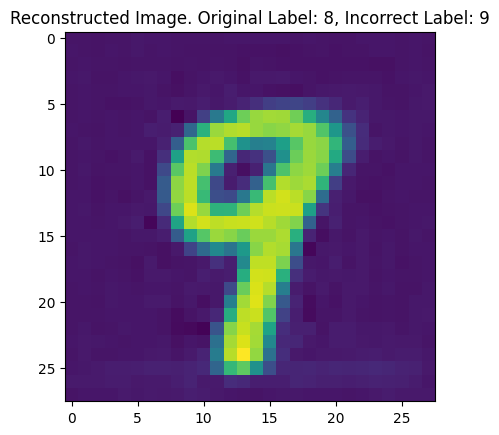

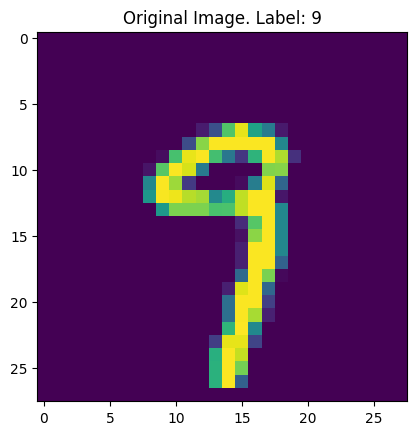

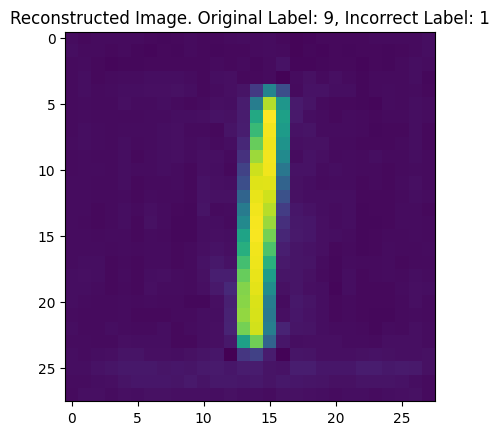

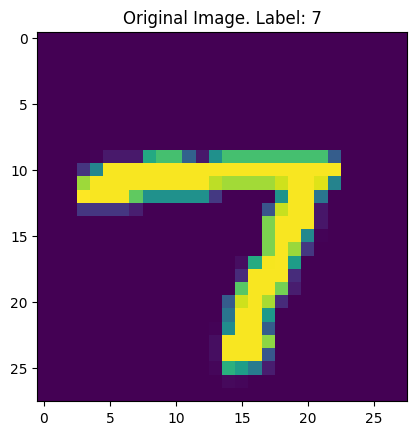

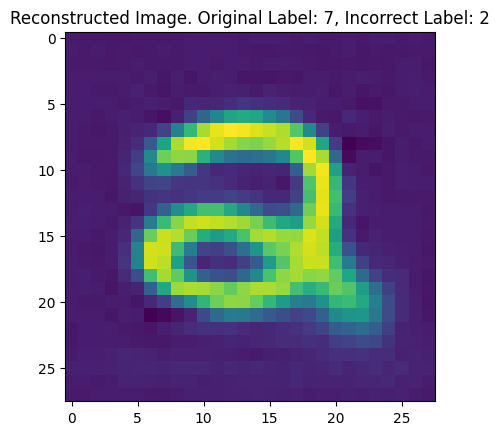

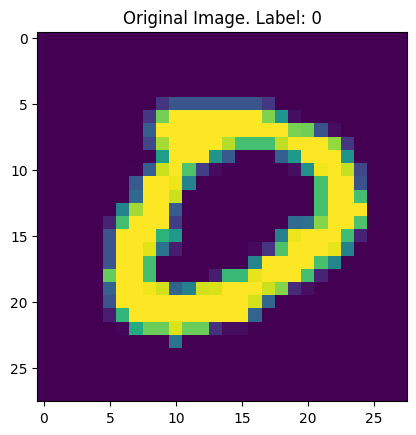

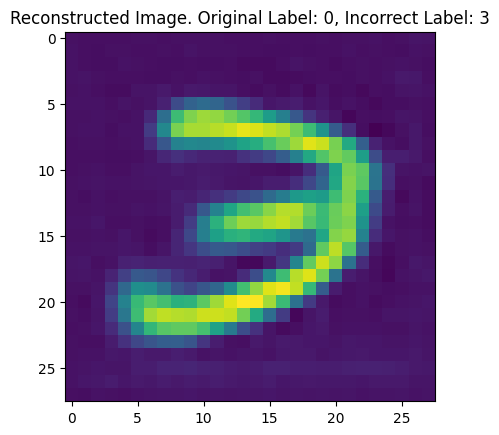

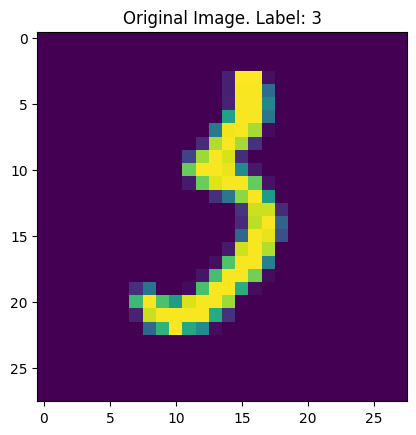

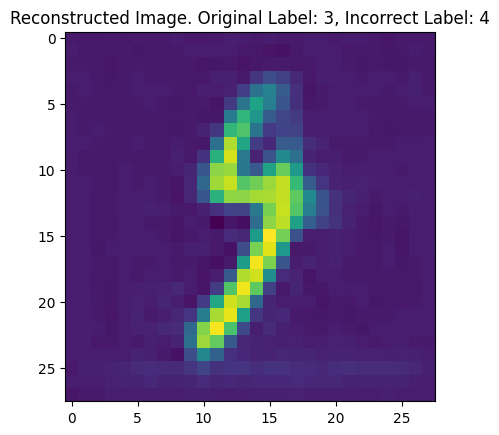

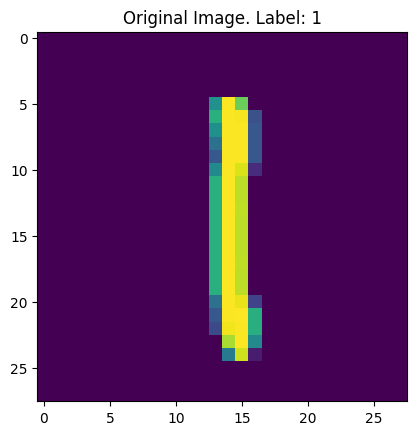

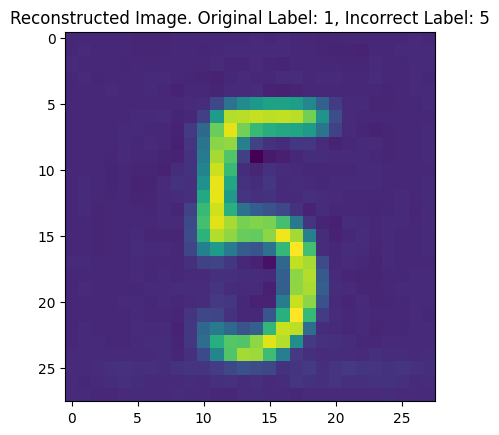

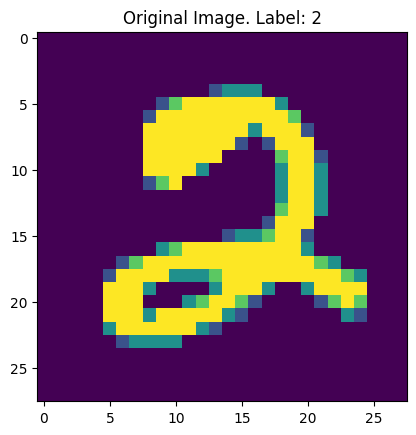

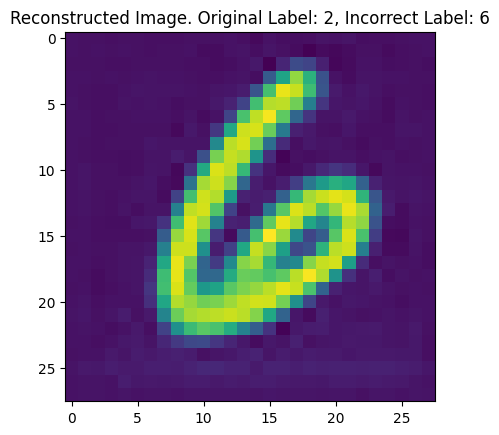

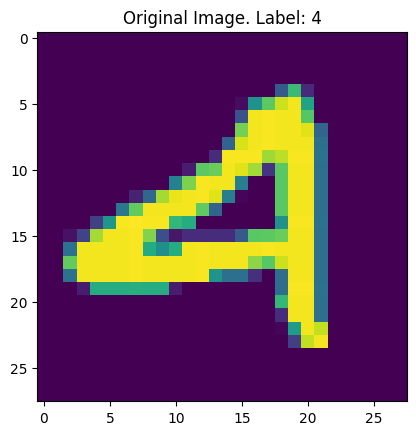

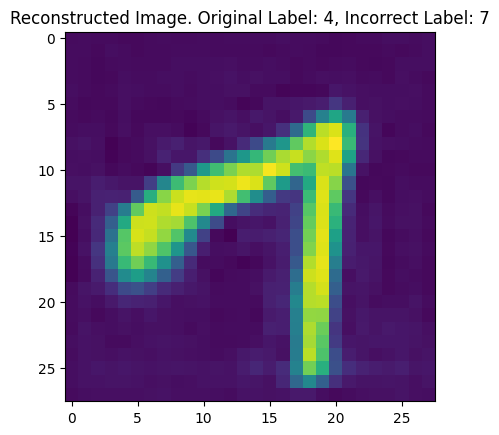

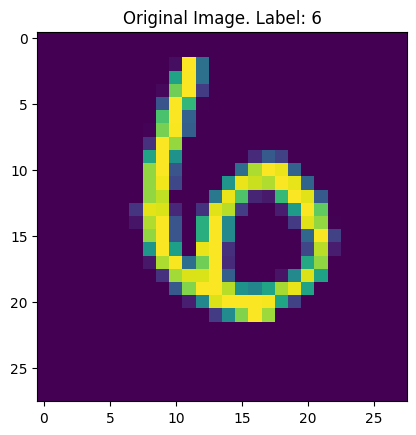

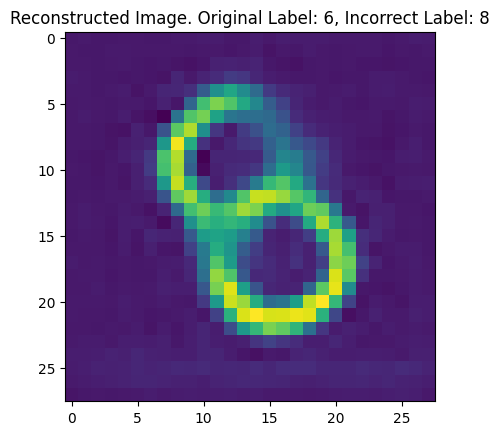

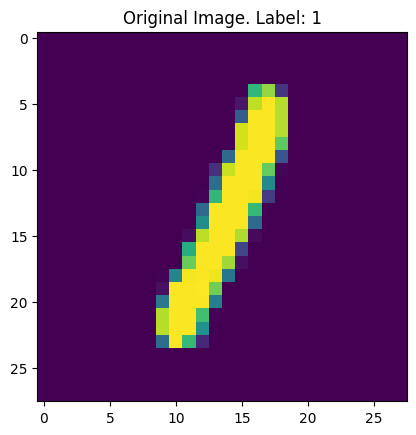

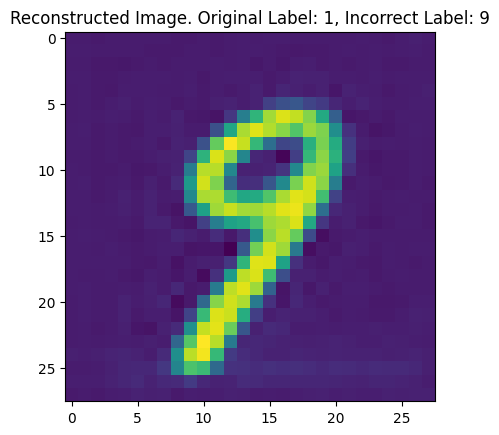

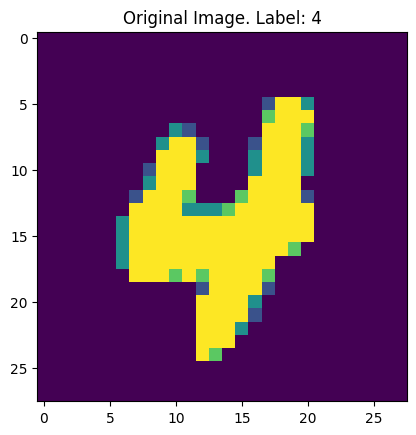

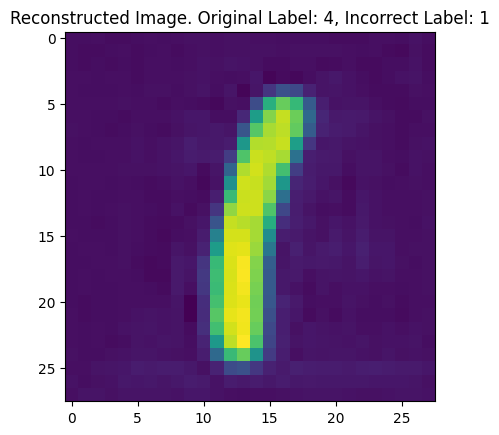

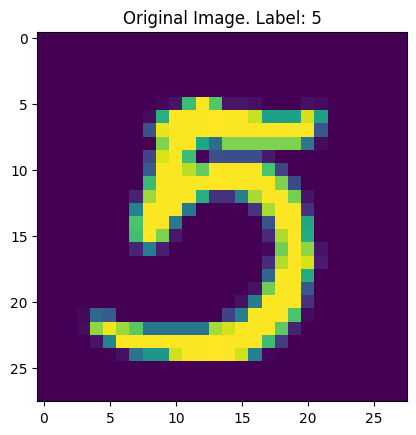

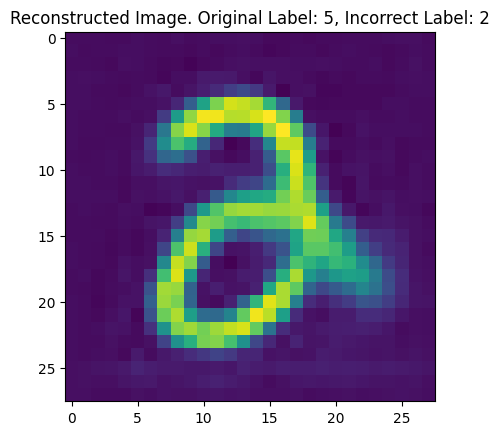

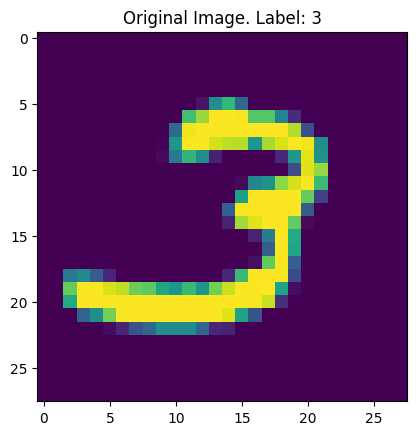

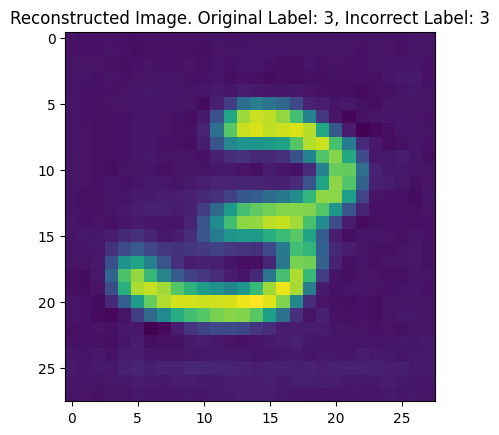

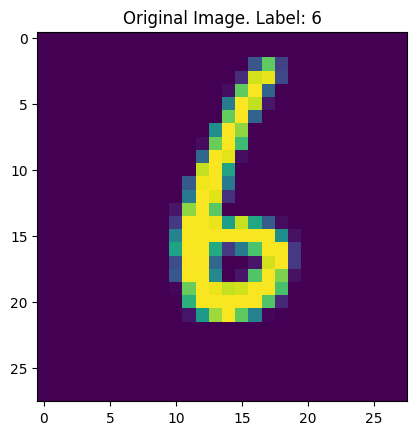

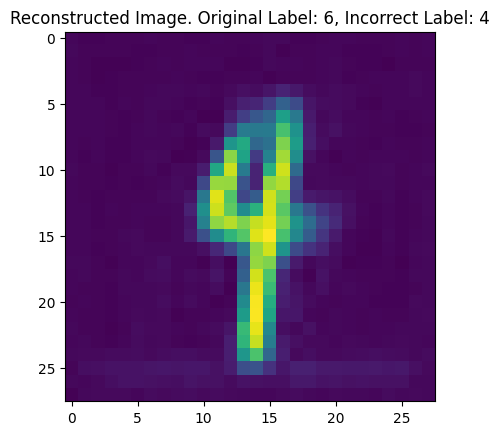

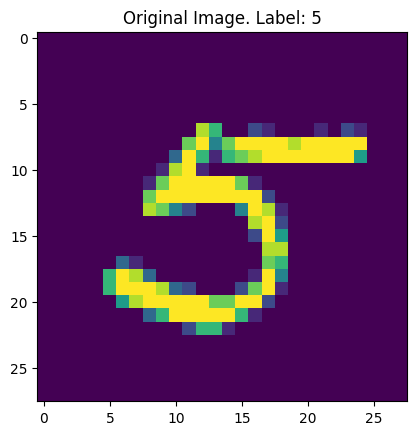

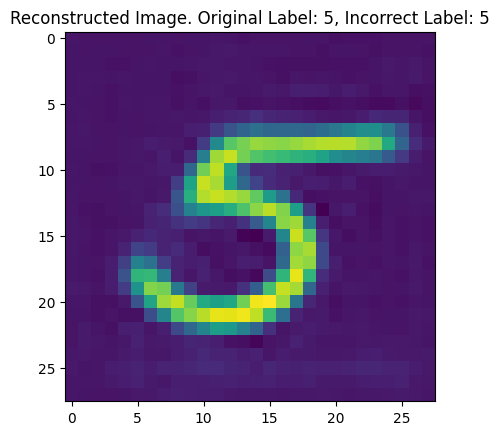

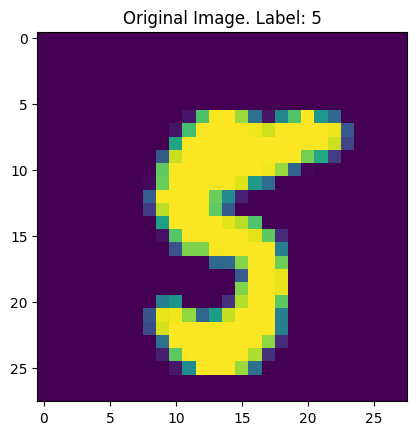

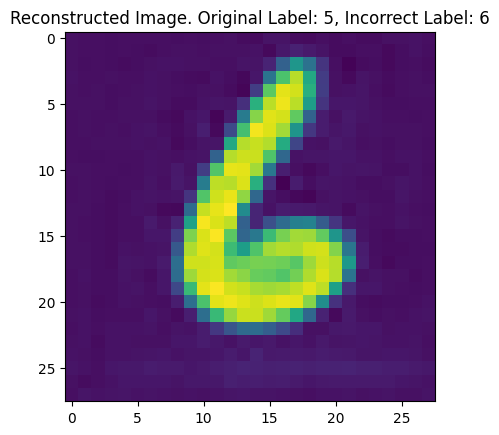

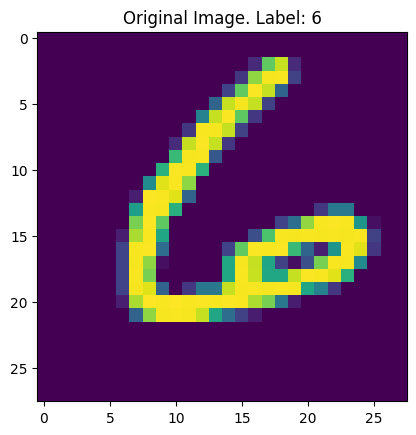

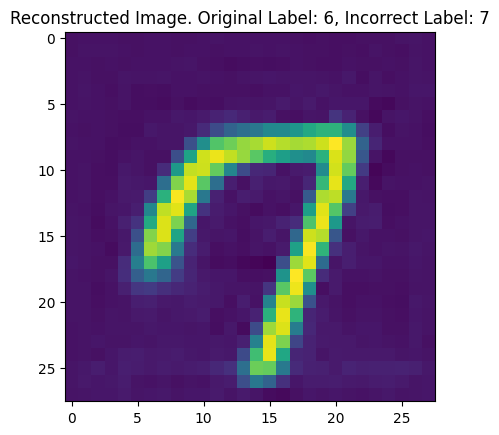

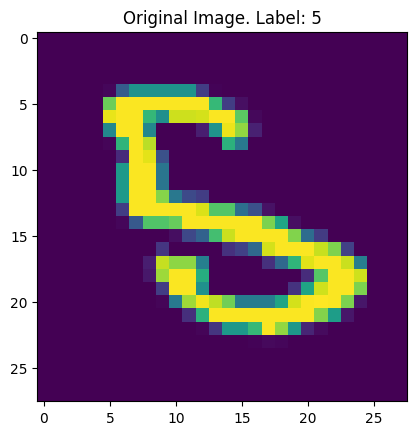

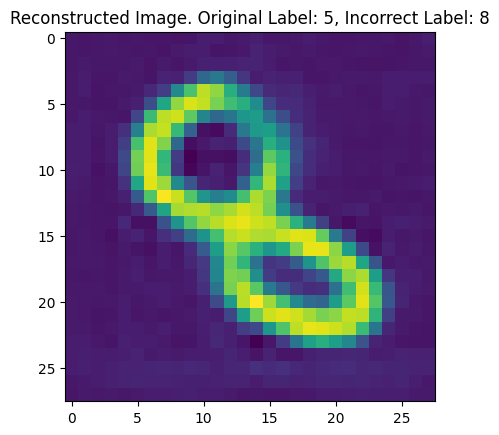

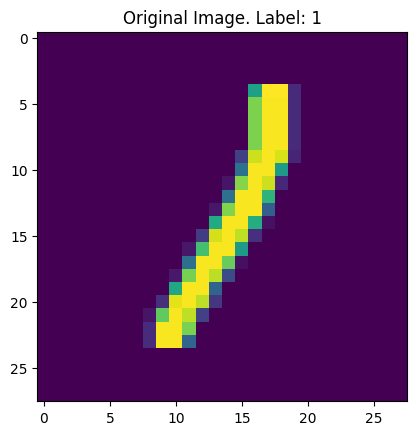

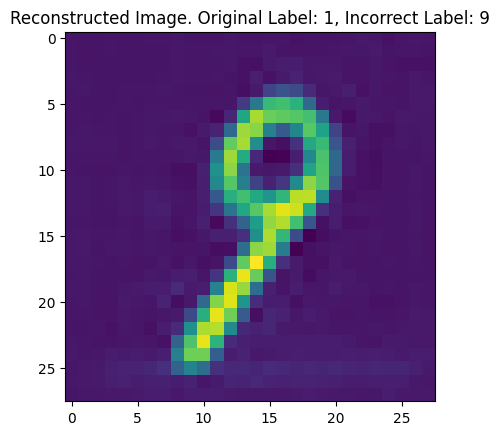

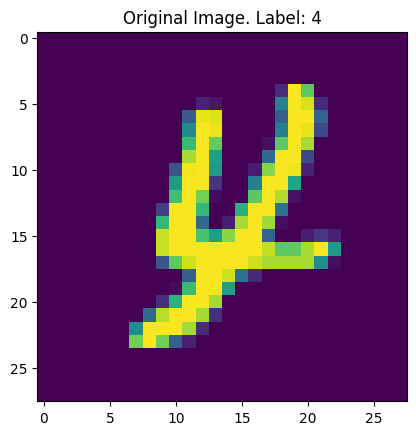

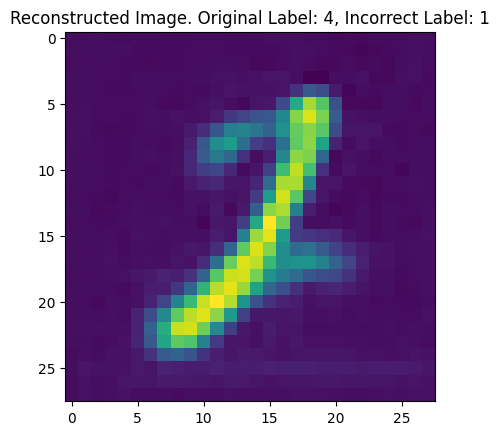

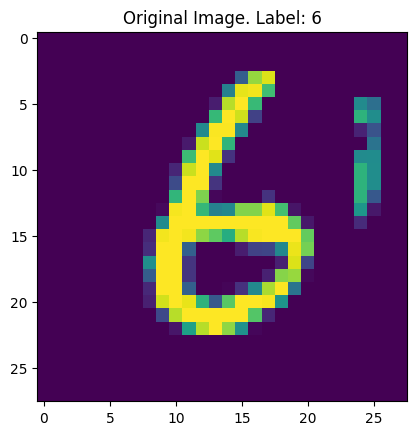

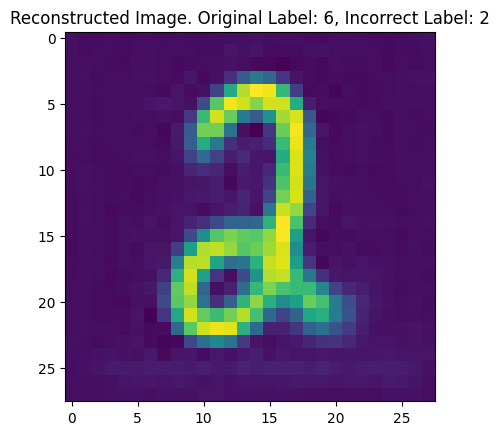

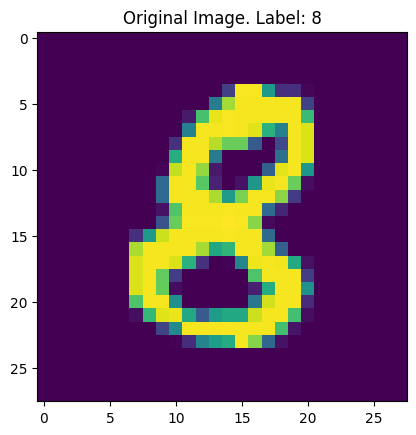

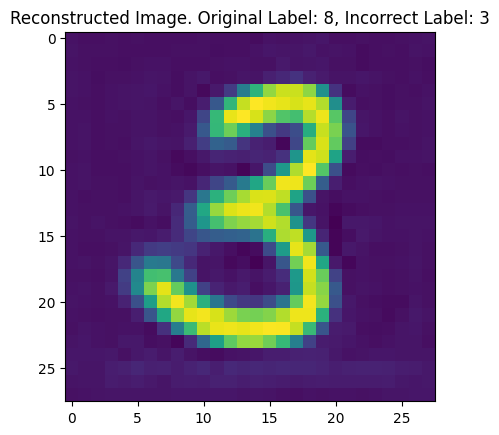

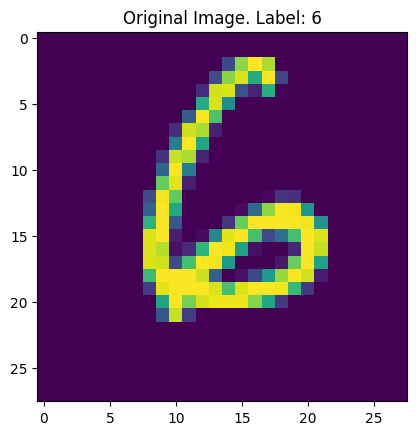

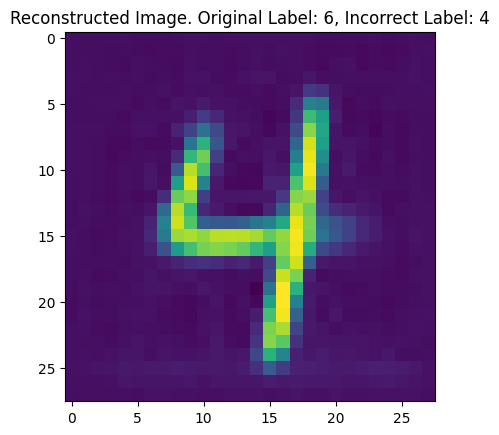

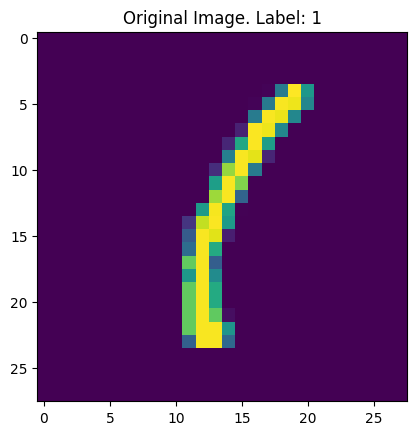

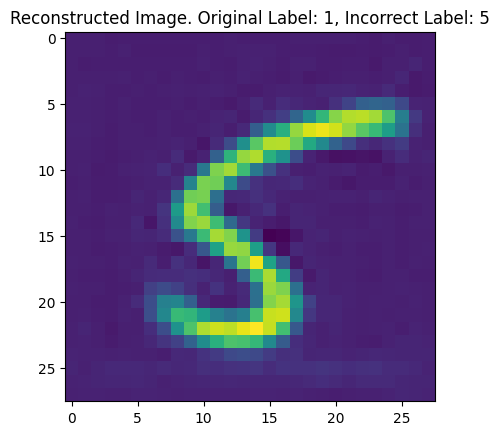

In [52]:
import matplotlib.pyplot as plt

mnist.setup()
data_loader = mnist.train_dataloader()

batch = next(iter(data_loader))
image, label = batch
print(label)
new_label = torch.LongTensor([1,2,3,4,5,6,7,8,9,1,2,3,4,5,6,7,8,9,1,2,3,4,5,6,7,8,9,1,2,3,4,5])
print(new_label)
output = vae(image, new_label)
for j in range(32):
    plt.figure()
    plt.title('Original Image. Label: {}'.format(label[j]))
    plt.imshow(image[j].squeeze().detach().numpy())
    plt.figure()
    plt.title('Reconstructed Image. Original Label: {}, Incorrect Label: {}'.format(label[j], new_label[j]))
    plt.imshow(output[j].squeeze().detach().numpy())